# Notebook de Pruebas para la API de Predicción de Temperatura
Este notebook está diseñado para realizar pruebas y validaciones sobre la API de predicción de temperatura desplegada en Render. Se incluyen ejemplos de uso de los distintos endpoints, pruebas con datos reales e inventados, y visualizaciones para comparar los resultados obtenidos.

El flujo del notebook es el siguiente:
1. Carga de librerías y configuración de la URL base de la API.
2. Descarga y preparación de datos históricos de temperatura para la estación Quinta Normal.
3. Pruebas de los endpoints principales de la API (`/`, `/predict`, `/predict_n`, `/model_performance`).
4. Visualización y análisis de los resultados obtenidos.

Cada sección incluye explicaciones y comentarios para facilitar la comprensión y el uso del notebook.

### Cargar librerías y configurar la URL base de la API

En esta celda se importan las librerías necesarias para realizar peticiones HTTP, manipular datos y visualizar resultados. Se configura la URL base de la API que será utilizada en las pruebas posteriores.

- `requests`: para realizar peticiones a la API.
- `IPython.display`: para mostrar HTML en el notebook.
- `pandas` y `numpy`: para manipulación y análisis de datos.
- `matplotlib` y `seaborn`: para visualización de resultados.

La variable `API_URL` almacena la dirección de la API desplegada en Render.

In [1]:
import requests
from IPython.display import display, HTML

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

API_URL = 'https://prediccion-temperatura-estacion-quinta.onrender.com'

### Cargar de datos de prueba

En esta sección se cargan los datos históricos de temperatura para la estación Quinta Normal desde la fuente oficial. Se utiliza una función personalizada que descarga los datos desde GitHub, filtra por estación y concatena los resultados en un DataFrame. Esto permite disponer de datos reales para probar los endpoints de la API.

La función `getVarDMC_y` permite automatizar la descarga y filtrado de los datos, facilitando la obtención de información para distintos años y estaciones.

In [2]:
# Función para descargar y filtrar datos históricos de temperatura desde GitHub para una estación y rango de años específico.
# Devuelve un DataFrame con los datos concatenados y procesados.
def getVarDMC_y(url: str, est: str, y_i: int, y_e: int) -> pd.DataFrame:
    var = url.split('/')[-2]
    data_frames = []
    for y in range(y_i, y_e + 1):
        url_ = f'{url}{y}/{y}_{var}.csv'
        try:
            df = pd.read_csv(url_)
            df = df[df['nombreEstacion'] == est]
            data_frames.append(df)
        except Exception as e:
            print(f"Error reading {url_}: {e}")
    if not data_frames:
        raise ValueError("No data frames were loaded. Check the URL and parameters.")
    df = pd.concat(data_frames, ignore_index=True)
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df['CodigoNacional'] = df['CodigoNacional'].astype(str)
    return df

# El modelo está definido para la estación Quinta Normal
# con datos de 2018 a 2023, para efectos de pruebas solo se toma 2023
estacion = 'Quinta Normal, Santiago'
year_ini = 2023
year_end = 2023

# Descarga y procesamiento de los datos de temperatura para la estación seleccionada.
df_temp = getVarDMC_y('https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/refs/heads/main/output/temperatura_dmc/', estacion, year_ini, year_end)

In [3]:
df_temp.head()

,time,latitud,longitud,Ts_Valor,CodigoNacional,nombreEstacion
0,2023-01-01 01:00:00,-33.445,-70.68278,16.7,330020.0,"Quinta Normal, Santiago"
1,2023-01-01 02:00:00,-33.445,-70.68278,16.3,330020.0,"Quinta Normal, Santiago"
2,2023-01-01 03:00:00,-33.445,-70.68278,16.3,330020.0,"Quinta Normal, Santiago"
3,2023-01-01 04:00:00,-33.445,-70.68278,16.2,330020.0,"Quinta Normal, Santiago"
4,2023-01-01 05:00:00,-33.445,-70.68278,16.0,330020.0,"Quinta Normal, Santiago"


A continuación se visualizan las primeras filas y la información general del DataFrame de temperatura descargado. Esto permite verificar la correcta carga y estructura de los datos antes de utilizarlos en las pruebas de la API.

In [4]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6511 entries, 0 to 6510
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            6511 non-null   datetime64[ns]
 1   latitud         6511 non-null   float64       
 2   longitud        6511 non-null   float64       
 3   Ts_Valor        6510 non-null   float64       
 4   CodigoNacional  6511 non-null   object        
 5   nombreEstacion  6511 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 305.3+ KB


### Prueba GET al endpoint raíz

En esta sección se realiza una petición GET al endpoint raíz (`/`) de la API. El objetivo es verificar que la API está activa y responde correctamente, mostrando el contenido HTML informativo que entrega el home del servicio.

In [5]:
response = requests.get(f'{API_URL}/')
print('Status code:', response.status_code)
display(HTML(response.text))

Status code: 200


### Prueba POST al endpoint /predict

En esta sección se prueba el endpoint `/predict` de la API, que permite obtener una predicción de temperatura a partir de valores históricos recientes. Se realizan dos pruebas: una con datos inventados y otra con datos reales extraídos del DataFrame.

Esto permite validar el funcionamiento del modelo y comparar la predicción con el valor real registrado.

In [6]:
# Prueba con data inventada
payload_predict = {
    'Ts_Valor_1h': 20.5,
    'Ts_Valor_2h': 20.1,
    'Ts_Valor_3h': 19.8,
    'Ts_Valor_24h': 18.7,
    'Ts_Valor_25h': 18.5
}
response = requests.post(f'{API_URL}/predict', json=payload_predict)
print('Status code:', response.status_code)
print('Respuesta:', response.json())

Status code: 200
Respuesta: {'predicted_temperature': 20.501222956298044}


In [7]:
# Prueba con datos reales
idx = 5200
payload_predict = {
    'Ts_Valor_1h': float(df_temp.iloc[idx+25].Ts_Valor),
    'Ts_Valor_2h': float(df_temp.iloc[idx+24].Ts_Valor),
    'Ts_Valor_3h': float(df_temp.iloc[idx+2].Ts_Valor),
    'Ts_Valor_24h': float(df_temp.iloc[idx+1].Ts_Valor),
    'Ts_Valor_25h': float(df_temp.iloc[idx].Ts_Valor)
}

response = requests.post(f'{API_URL}/predict', json=payload_predict)

print('Predicción para el', df_temp.iloc[idx+26].time)
print("---------------------------------------")
print('Status code:', response.status_code)
print('Predicción:', response.json()['predicted_temperature'])
print('Valor Real:', float(df_temp.iloc[idx+26].Ts_Valor))

Predicción para el 2023-08-06 19:00:00
---------------------------------------
Status code: 200
Predicción: 16.958558581462007
Valor Real: 17.3


## Prueba POST al endpoint /predict_n

En esta sección se prueba el endpoint `/predict_n`, que permite obtener una secuencia de predicciones de temperatura para las próximas n horas, utilizando los últimos 25 valores registrados.

Se realizan pruebas con datos inventados y con datos reales, y se visualizan los resultados para comparar la predicción con los valores observados.

In [8]:
# Prueba con data inventada
payload_predict_n = {
    'data': [18.5, 18.7, 19.8, 20.1, 20.5, 20.0, 19.5, 19.0, 18.8, 18.6,
             18.4, 18.2, 18.0, 17.8, 17.6, 17.4, 17.2, 17.0, 16.8, 16.6,
             16.4, 16.2, 16.0, 15.8, 15.6],
    'hours': 4
}
response = requests.post(f'{API_URL}/predict_n', json=payload_predict_n)
print('Status code:', response.status_code)
print('Respuesta:', response.json())

Status code: 200
Respuesta: {'predicted_temperature': [15.79747125369243, 16.596261638301122, 17.177702832137506, 17.759080773443685]}


In [9]:
# Función para probar el endpoint /predict_n de la API.
# Envía una secuencia de 25 valores de temperatura y solicita la predicción para las siguientes n horas.
# Grafica la comparación entre la predicción y los valores reales.
def predict_n_show(df_temp, idx, n_hours, API_URL):
    df_temp_TS_test = df_temp.iloc[idx:(idx+25)].Ts_Valor.tolist()
    df_temp_TS_real = df_temp.iloc[(idx+25):(idx+25+n_hours)].Ts_Valor.tolist()

    payload_predict_n = {
        'data': df_temp_TS_test,
        'hours': n_hours
    }
    response = requests.post(f'{API_URL}/predict_n', json=payload_predict_n)

    print(f'Predicción para el {df_temp.iloc[idx+25].time} por {n_hours} horas.')
    print("----------------------------------------------------")

    print('Status code:', response.status_code)
    print('Respuesta:', response.json()['predicted_temperature'])
    print('Valor Real:', df_temp_TS_real)

    #Grafico
    plt.figure(figsize=(15, 3))
    plt.plot(response.json()['predicted_temperature'], label="Predicción", color="#009688", linewidth=2)
    plt.plot(df_temp_TS_real, label="Real", color="#f44336", linewidth=2, linestyle="--")
    plt.title("Temperatura Predicha vs Real", fontsize=14)
    plt.xlabel("Tiempo (hrs)", fontsize=12)
    plt.ylabel("Temperatura (°C)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plt.show()

Predicción para el 2023-03-05 14:00:00 por 10 horas.
----------------------------------------------------
Status code: 200
Respuesta: [26.090789136666736, 28.291231119206238, 30.177324305649478, 31.247221074254163, 32.03983965136449, 32.60003617723552, 32.560017580831214, 32.123803485329795, 30.799371776415526, 28.765103371743848]
Valor Real: [25.7, 28.4, 29.9, 30.0, 31.5, 31.4, 31.2, 29.7, 26.9, 24.3]


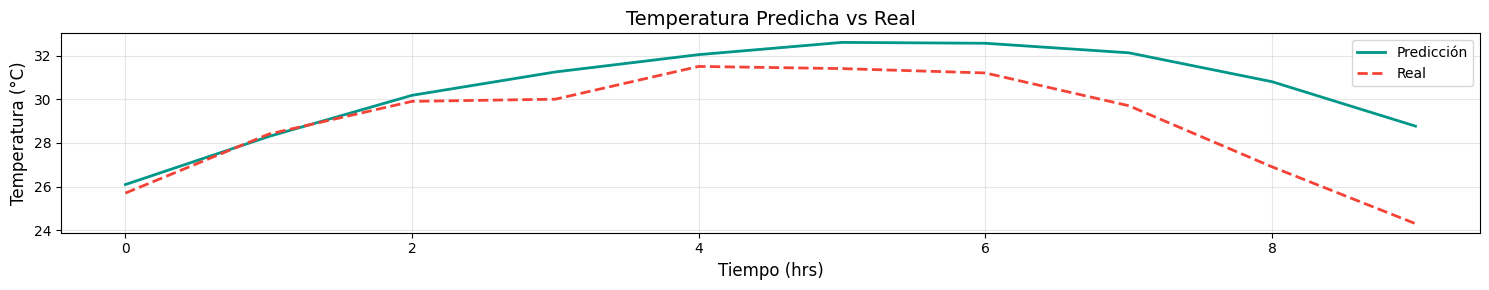

In [10]:
idx = 1500
n_hours = 10
predict_n_show(df_temp, idx, n_hours, API_URL)

Predicción para el 2023-05-27 22:00:00 por 10 horas.
----------------------------------------------------
Status code: 200
Respuesta: [17.255776965805232, 15.427208122274328, 14.586184606959042, 13.446438667595254, 12.642767254722758, 12.227954120207382, 11.93996418944668, 12.061311423638642, 11.90793617154926, 11.910662200919688]
Valor Real: [15.9, 12.8, 10.5, 9.1, 8.5, 7.6, 7.3, 6.6, 6.6, 6.2]


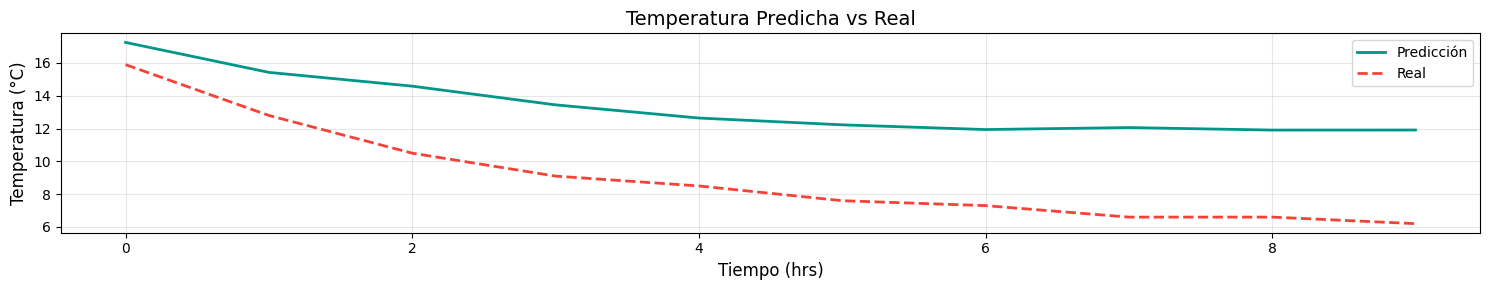

In [11]:
idx = 3500
n_hours = 10
predict_n_show(df_temp, idx, n_hours, API_URL)

Predicción para el 2023-08-06 18:00:00 por 10 horas.
----------------------------------------------------
Status code: 200
Respuesta: [15.910784390967942, 15.797786409389573, 15.717173076833287, 15.536544921364372, 15.199597867056164, 14.889481100849766, 14.554658268214977, 14.189098134885468, 13.837484676320544, 13.350733915745648]
Valor Real: [16.4, 17.3, 17.3, 17.0, 15.6, 13.3, 10.4, 8.8, 8.6, 7.8]


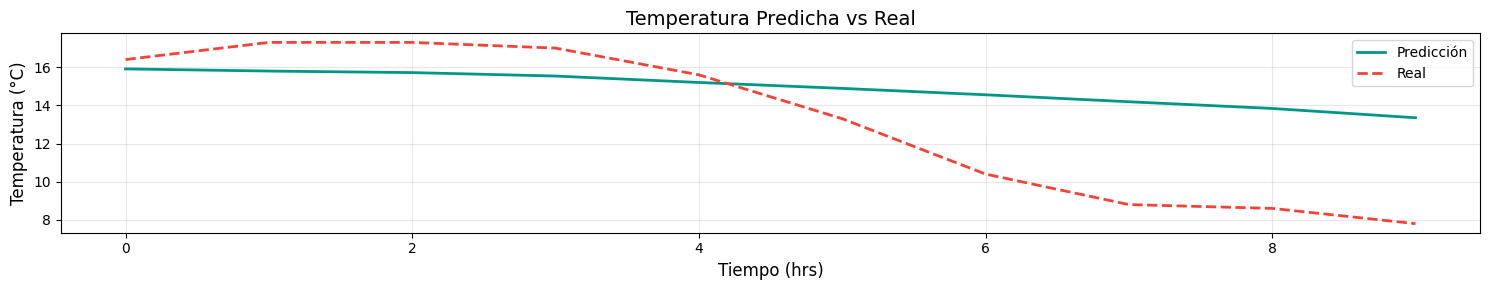

In [12]:
idx = 5200
n_hours = 10
predict_n_show(df_temp, idx, n_hours, API_URL)

Predicción para el 2023-09-09 02:00:00 por 10 horas.
----------------------------------------------------
Status code: 200
Respuesta: [11.408861889285836, 11.184398446293603, 11.030337885845961, 11.195399694970035, 11.091764465332497, 10.80667165731371, 10.702771754754787, 10.482862630561522, 10.45064471567869, 10.685348434051916]
Valor Real: [11.8, 11.6, 11.3, 11.3, 10.6, 10.2, 10.3, 10.2, 10.4, 11.0]


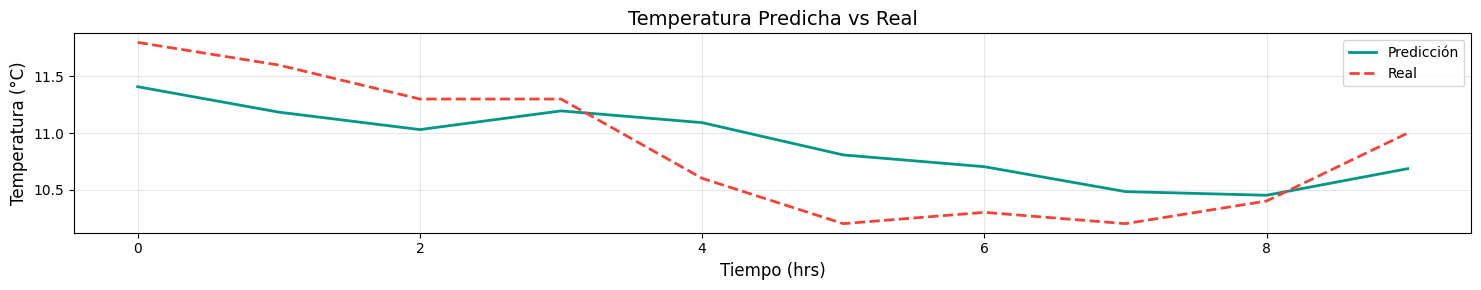

In [13]:
idx = 6000
n_hours = 10
predict_n_show(df_temp, idx, n_hours, API_URL)

## Prueba POST al endpoint /model_performance

En esta sección se prueba el endpoint `/model_performance`, que permite evaluar el rendimiento del modelo de predicción utilizando una secuencia de datos reales. La API retorna métricas como RMSE, medias y desviaciones estándar, además de las series de temperatura predicha y observada.

Se visualizan los resultados y se analizan las métricas para validar la calidad de las predicciones.

In [14]:
# Prueba con data inventada
payload_performance = {
    'data': [18.5, 18.7, 19.8, 20.1, 20.5, 20.0, 19.5, 19.0, 18.8, 18.6,
             18.4, 18.2, 18.0, 17.8, 17.6, 17.4, 17.2, 17.0, 16.8, 16.6,
             16.4, 16.2, 16.0, 15.8, 15.6, 15.4, 15.2],
}
response = requests.post(f'{API_URL}/model_performance', json=payload_performance)
print('Status code:', response.status_code)
print('Respuesta:', response.json())

Status code: 200
Respuesta: {'predicted_temperature': [15.79747125369243, 16.110160109746595], 'real_temperature': [15.4, 15.2], 'rmse': [0.7022730319775089], 'mean_true': [15.3], 'mean_pred': [15.953815681719512], 'std_true': [0.10000000000000053], 'std_pred': [0.15634442802708204]}


In [15]:
# Función para probar el endpoint /model_performance de la API.
# Envía una secuencia de datos reales y recibe las métricas de rendimiento del modelo junto con las series predicha y observada.
# Grafica la comparación y muestra las métricas principales.
def model_performance_show(df_temp, idx, n_delay, API_URL):
    df_temp_TS_test = df_temp.iloc[idx:(idx+n_delay)].Ts_Valor.tolist()
    payload_performance = {
    'data': df_temp_TS_test,
    }
    response = requests.post(f'{API_URL}/model_performance', json=payload_performance)

    predicted_temperature = response.json()['predicted_temperature']
    real_temperature = response.json()['real_temperature']
    rmse = response.json()['rmse'][0]
    mean_true = response.json()['mean_true'][0]
    mean_pred = response.json()['mean_pred'][0]
    std_true = response.json()['std_true'][0]
    std_pred = response.json()['std_pred'][0]

    print(f'Rendimiento del modelo para el {df_temp.iloc[idx].time} por {int(n_delay/24)} días.')
    print("----------------------------------------------------------------")
    print('Status code:', response.status_code)
    print('Respuesta :', response.json())
    print()
    print(f'rmse      : {rmse}')
    print(f'mean_true : {mean_true}')
    print(f'mean_pred : {mean_pred}')
    print(f'std_true  : {std_true}')
    print(f'std_pred  : {std_pred}')

    #Grafico
    plt.figure(figsize=(15, 3))
    plt.plot(predicted_temperature, label="Predicción", color="#009688", linewidth=2)
    plt.plot(real_temperature, label="Real", color="#f44336", linewidth=2, linestyle="--")
    plt.title("Temperatura Predicha vs Real", fontsize=14)
    plt.xlabel("Tiempo (hrs)", fontsize=12)
    plt.ylabel("Temperatura (°C)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plt.show()


Rendimiento del modelo para el 2023-02-11 17:00:00 por 14 días.
----------------------------------------------------------------
Status code: 200
Respuesta : {'predicted_temperature': [31.49349098610785, 31.277200147306026, 31.455242523035878, 30.455874800438373, 29.522523884192026, 25.75917520531737, 22.228379632182303, 21.352094678374442, 19.633352464094997, 18.535904875674532, 16.876451136216104, 16.89133335450171, 16.225459715398948, 16.552246402379915, 14.320880324833674, 13.029365962212518, 12.79758247373009, 13.12496579915336, 15.379978992777492, 20.051955576799408, 21.536160100314767, 23.552243465605734, 25.334604132986968, 27.84142810823044, 29.7133278844371, 30.01411922387495, 30.763637925090336, 31.0457399047734, 28.311226613855027, 27.249579194565456, 25.808722549744452, 22.58128674121979, 21.117639398627418, 20.714070924947215, 19.53828417630026, 18.573859920471953, 17.02564536877827, 14.903123981006708, 15.155524884198401, 14.144426946698447, 14.255758543177363, 14.353402

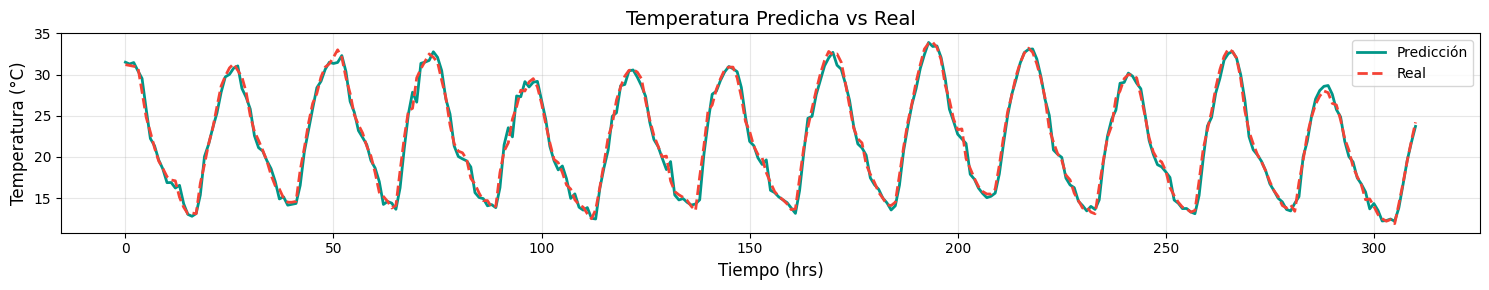

In [16]:
# Prueba con datos reales
idx = 1000
n_delay = 24*14 #14 dias
model_performance_show(df_temp, idx, n_delay, API_URL)

Rendimiento del modelo para el 2023-05-06 01:00:00 por 14 días.
----------------------------------------------------------------
Status code: 200
Respuesta : {'predicted_temperature': [6.108043300461623, 5.957569237451075, 5.950699175304799, 6.381999488744263, 5.23321676733705, 4.6559707600765154, 4.943493650038931, 4.778635697812353, 4.007222100996095, 3.345462751557535, 3.5688657975820535, 5.350297046759771, 7.513290764116133, 11.99706439105247, 14.057345929881674, 17.112449017551768, 19.196231215799365, 21.09817775848333, 22.19173672686768, 21.201500700999745, 18.85513511090729, 12.512925106398802, 10.819677319171875, 10.19712725408238, 7.982856992936091, 8.140599921425302, 7.839341475322462, 5.871170840924031, 5.669530940895765, 6.027257355328395, 5.276106369308565, 4.80446849059661, 4.535252658299039, 4.587842919215898, 4.029960062416922, 4.967472814693138, 10.308741027402794, 18.610217186263263, 19.827533310182687, 22.854438029604673, 24.523332826179065, 26.19904765571173, 26.397

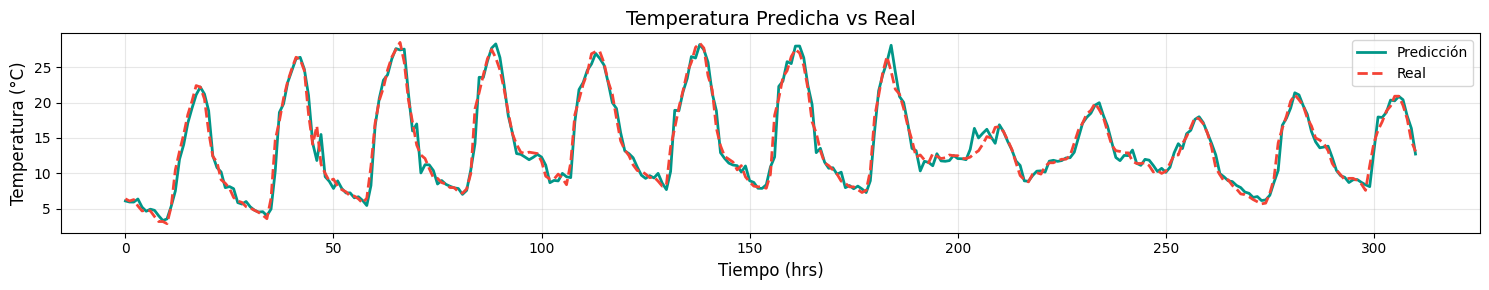

In [17]:
# Prueba con datos reales
idx = 3000
n_delay = 24*14 #14 dias
model_performance_show(df_temp, idx, n_delay, API_URL)

Rendimiento del modelo para el 2023-07-28 09:00:00 por 14 días.
----------------------------------------------------------------
Status code: 200
Respuesta : {'predicted_temperature': [7.693990490271408, 7.466082049098196, 7.045458829168583, 7.865436375150365, 10.173473290773991, 19.585562370021975, 21.42577637347992, 22.962810980732826, 23.825983474070462, 25.664185423163957, 25.245266894869744, 24.274255085604125, 19.66358972169943, 17.1780185904055, 11.939040093970302, 13.966365394747124, 11.43948010080126, 12.1864378286721, 9.710037973092588, 10.023016233201853, 9.329937803233886, 8.667717357155594, 8.971300417923874, 9.122147093570048, 8.434403595845058, 8.889945066762358, 8.397267442064448, 10.243641108260084, 14.873243900046447, 18.142689518384046, 18.839703202885325, 20.094369378063504, 22.301729392219265, 23.420156515999388, 23.0205783190154, 21.613120984093612, 18.791451013779408, 15.088078173927506, 13.36381201958857, 12.508214846760433, 11.523919239741595, 10.89364252178582

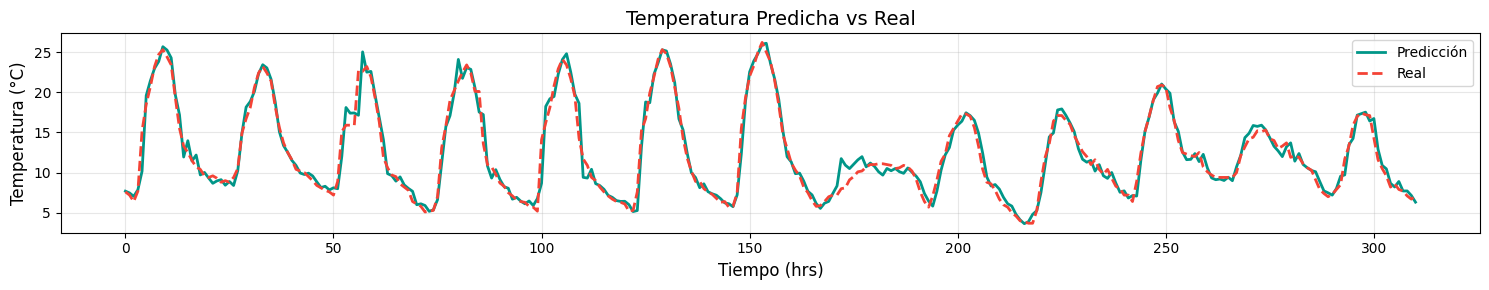

In [18]:
# Prueba con datos reales
idx = 5000
n_delay = 24*14 #14 dias
model_performance_show(df_temp, idx, n_delay, API_URL)

Rendimiento del modelo para el 2023-09-08 01:00:00 por 14 días.
----------------------------------------------------------------
Status code: 200
Respuesta : {'predicted_temperature': [11.408861889285836, 11.662754633634922, 11.447261841125545, 11.398833416238558, 11.125582066434648, 10.16062459604412, 10.067839012198077, 10.16879895162611, 10.244213307643074, 10.719639811829945, 11.330583249464548, 11.36344025326654, 12.33964233904565, 14.17484616863238, 14.57492677502434, 13.767615676141215, 15.578055424478302, 17.002025597812903, 16.509619281813805, 16.349605473084914, 14.900929075399956, 13.990040001859265, 12.682834973764022, 12.145458515891255, 11.748113856611495, 10.8906335367147, 10.491075387904699, 10.451694276937397, 9.571528220257745, 10.074847012009068, 10.18813695498885, 10.584188520089587, 10.531218618708023, 10.384610776466742, 9.86234719454429, 10.85585941145184, 12.346408481167193, 11.914913988901471, 12.736365321368373, 13.723396743001889, 13.413210072478996, 14.19450

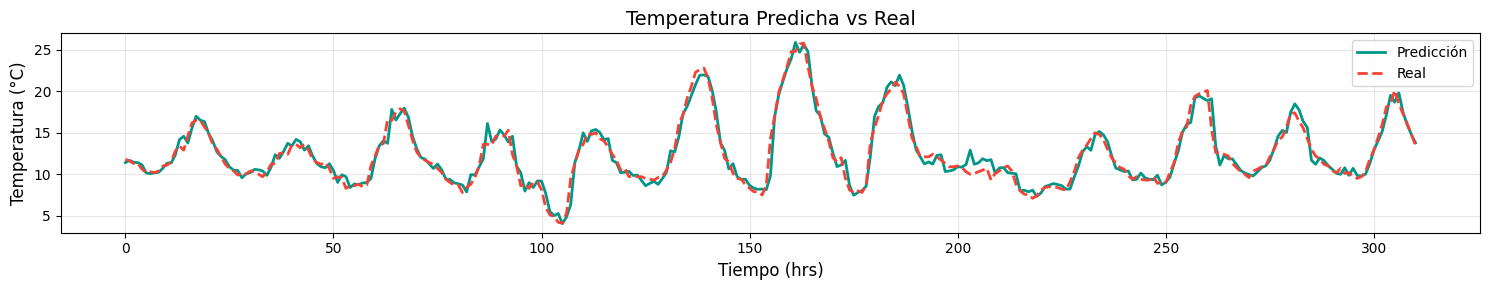

In [19]:
# Prueba con datos reales
idx = 6000
n_delay = 24*14 #14 dias
model_performance_show(df_temp, idx, n_delay, API_URL)